In [345]:
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium.plugins import HeatMap
from datetime import datetime
import numpy as np
from IPython.display import HTML
import os
import random

# Pick run and settings

In [357]:
print("Possible runs:")
runs = os.listdir(os.path.join(os.getcwd(), 'runs'))
print(runs)

Possible runs:
['.DS_Store', '04_04_2024_10-55-40', '04_04_2024_11-26-35', '04_04_2024_11-32-58', 'run_name.txt', '04_04_2024_11-06-31', '04_04_2024_11-54-44']


In [369]:
# run index (0,1,2,3...)
run_index = 2
# threshold for confidences on map
conf_threshold = 0.75

In [370]:
run_path = os.path.join(os.getcwd(), 'runs', runs[run_index])
print("run path: ", run_path)

run path:  /Users/robertobrien/Documents/Thesis/Code/runs/04_04_2024_11-26-35


# Plot temperatures over time

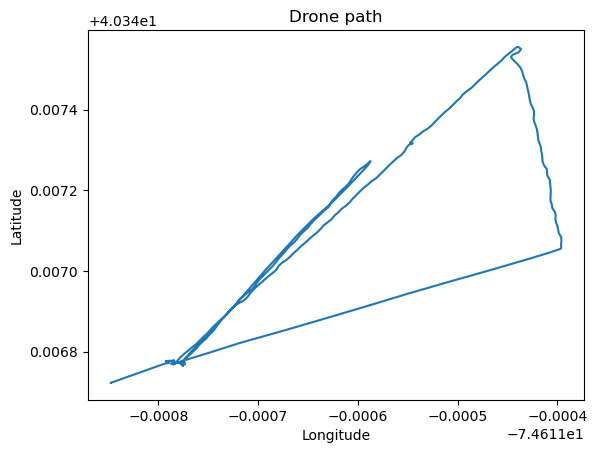

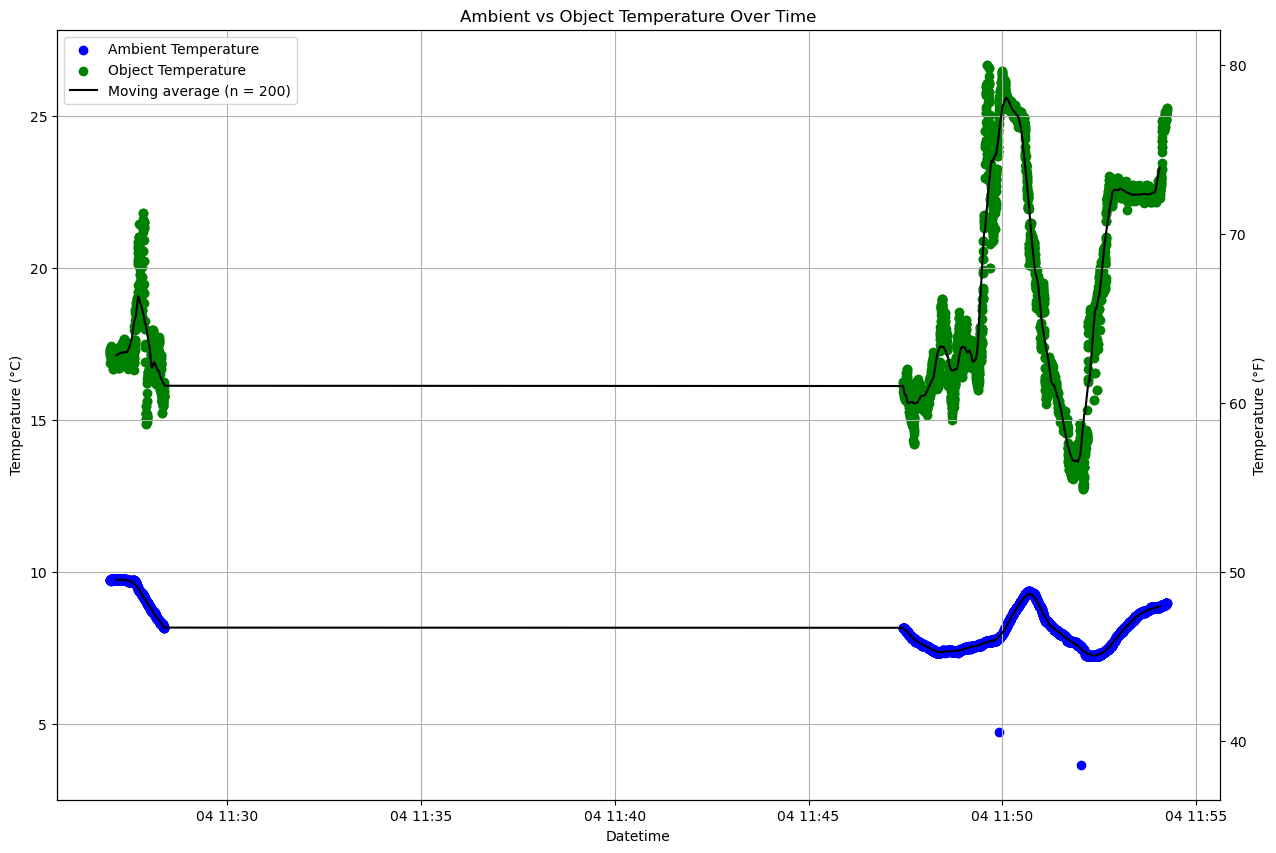

0 days 00:27:16.111799


In [416]:
file_path = os.path.join(run_path, 'temps.txt')

rate = 10 #in Hz, rate we're capturing data
window_secs = 10
window_size = 2*window_secs*rate

df = pd.read_csv(file_path, parse_dates=['datetime'])

#drop na value
df = df.dropna(subset=['latitude', 'longitude', 'object_temperature'])

#print general path
plt.plot(df['longitude'], df['latitude'])
plt.figsize=(15, 10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Drone path')
plt.show()

fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.scatter(df['datetime'], df['ambient_temperature'], label='Ambient Temperature', color='blue')
ax1.scatter(df['datetime'], df['object_temperature'], label='Object Temperature', color='green')
ax1.set_xlabel('Datetime')
ax1.set_ylabel(
    'Temperature (°C)')
ax1.legend()
df['ambient_temperature_moving_avg'] = df['ambient_temperature'].rolling(window=window_size, center=True).mean()
df['object_temperature_moving_avg'] = df['object_temperature'].rolling(window=window_size, center=True).mean()
df['temperature_dif'] = df['ambient_temperature'] - df['object_temperature']
df['t'] = df['datetime'] - df['datetime'].min()

ax2 = ax1.twinx()
ax2.set_ylabel('Temperature (°F)')
celsius_limits = ax1.get_ylim()
ax2.set_ylim(celsius_limits[0] * 9/5 + 32, celsius_limits[1] * 9/5 + 32)

moving_avg_label = 'Moving average (n = '+str(window_size) + ")"
ax1.plot(df['datetime'], df['ambient_temperature_moving_avg'], color='black', linestyle='-')

ax1.plot(df['datetime'], df['object_temperature_moving_avg'], label=moving_avg_label, color='black', linestyle='-')
ax1.grid(True)
ax1.legend()
plt.title('Ambient vs Object Temperature Over Time')
plt.show()

# Get time of run
length = df['datetime'].max() - df['datetime'].min()
print(length)

# Get more details about the run...
#df.describe().to_latex() # to latex for the results section of thesis

# Plot temperatures for each location

In [417]:
import numpy as np
import folium
from scipy.interpolate import griddata
import branca.colormap as cm

#look at only first 'n'
#df = df.head(1600)


#create map
temperature_map = folium.Map(control_scale=False, location=[df['latitude'].mean(), df['longitude'].mean()],tiles="Esri.WorldImagery", zoom_start=19)

# add color map guide in the top right
colormap = folium.LinearColormap(colors=['blue', 'cyan', 'lime', 'yellow', 'red'], vmin=min(df['object_temperature'])-0.5, vmax=max(df['object_temperature'])+0.5, caption='Object Temperature (°C)')
temperature_map.add_child(colormap)

#place markers at each location corresponding to their temperature
for i, row in df.iterrows():
    temp = row['object_temperature']
    temperature_color = colormap(temp)
    folium.Circle(location=[row['latitude'], row['longitude']], color=temperature_color, fill=True, fill_opacity=0.1, radius=0.05
            ).add_to(temperature_map)
    
#datetime range to mark on map
df['datetime'] = pd.to_datetime(df['datetime'])
datetime_range = f"{df['datetime'].min().strftime('%Y-%m-%d %H:%M:%S')} to {df['datetime'].max().strftime('%Y-%m-%d %H:%M:%S')}"

caption_html = f"""
<div style='position: fixed; 
     top: 50px; left: 50px;
     background-color: white; padding: 10px; 
     z-index:9999; font-size:14px;'>
     Datetime Range: {datetime_range}
</div>
"""
temperature_map.get_root().html.add_child(folium.Element(caption_html))

# save the map to an HTML file, make it openable
temperature_map.save('temperature_map.html')
print("map saved to: temperature_map.html")
HTML(f'<a href="{"temperature_map.html"}" target="_blank">Access map here</a>')
temperature_map

map saved to: temperature_map.html


# Plot map for detections above a threshold

In [373]:
file_path = os.path.join(run_path, 'detections.txt')

data = pd.read_csv(file_path, parse_dates=['datetime'])
print(data.size, "detections")
data

2114 detections


,datetime,fname,label,confidence,latitude,longitude,altitude
0,2024-04-04 11:27:02.681150,filename-placeholder,shark,0.740243,40.346772,-74.611792,34.86
1,2024-04-04 11:27:02.681617,filename-placeholder,shark,0.712156,40.346772,-74.611792,34.86
2,2024-04-04 11:27:02.681899,filename-placeholder,shark,0.710302,40.346772,-74.611792,34.86
3,2024-04-04 11:27:04.374825,filename-placeholder,shark,0.746275,40.346772,-74.611791,34.90
4,2024-04-04 11:27:04.375247,filename-placeholder,shark,0.670826,40.346772,-74.611791,34.90
...,...,...,...,...,...,...,...
297,2024-04-04 11:54:38.033168,filename-placeholder,shark,0.592840,40.346766,-74.611774,33.40
298,2024-04-04 11:54:38.033474,filename-placeholder,shark,0.541981,40.346766,-74.611774,33.40
299,2024-04-04 11:54:38.033752,filename-placeholder,person,0.530130,40.346766,-74.611774,33.40
300,2024-04-04 11:54:38.034009,filename-placeholder,person,0.522567,40.346766,-74.611774,33.40


In [381]:
print("run path: ", run_path)
print("detections.txt path: ", file_path)

# Load the data
#file_path = 'detections3.txt'
data = pd.read_csv(file_path, parse_dates=['datetime'])
data = data.dropna(subset=['latitude', 'longitude'])


# init map
detection_map = folium.Map(control_scale=True, location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=19, tiles="Esri.WorldImagery")

# add markers
for i, row in data.iterrows():
    
    row['fname'] = '04_04_2024_11-55-09_image' # manually set. comment out once working 
    img_path = run_path + row['fname'] # keep
    img_path = os.path.join(run_path, random.choice(os.listdir(run_path))) # random, comment out once working. 
    img_html = f'<a href="file://{img_path}" target="_top">See image</a>' # keep
    
    if row['label'] == 'shark' and row['confidence']>conf_threshold:
        html_content = f"""
        <div style='width: 100%; max-width: 1500px;'>
            <p>Confidence: {np.round(row['confidence'],4)}</p>
            <p>Latitude: {row['latitude']}</p>
            <p>Longitude: {row['longitude']}</p>
            <p>Altitude: {row['altitude']}</p>
            <p>Datetime: {row['datetime']}</p>
            <p>File name: {row['fname']}</p>
        </div>
        """ + img_html
        iframe = folium.IFrame(html=html_content, width=400, height=250)
        popup = folium.Popup(iframe, max_width=300)
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup,
            tooltip=row['label'],
            icon=folium.Icon(icon='fa-fish', prefix='fa', color='blue')
        ).add_to(detection_map)
    if row['label'] == 'person' and row['confidence']>conf_threshold:
        html_content = f"""
        <div style='width: 100%; max-width: 1500px;'>
            <p>Confidence: {np.round(row['confidence'],4)}</p>
            <p>Latitude: {row['latitude']}</p>
            <p>Longitude: {row['longitude']}</p>
            <p>Altitude: {row['altitude']}</p>
            <p>Datetime: {row['datetime']}</p>
            <p>File name: {row['fname']}</p>
        </div> 
        """ + img_html
        iframe = folium.IFrame(html=html_content, width=400, height=250)
        popup = folium.Popup(iframe, max_width=300)
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup,
            tooltip=row['label'],
            icon=folium.Icon(icon='fa-person', prefix='fa', color='blue')
        ).add_to(detection_map)

# save map
detection_map.save('detection_map.html')
print("detection map saved to: detection_map.html")
# display in notebook
#HTML(f'<a href="{"detection_map.html"}" target="_blank">Access map here</a>')
detection_map

run path:  /Users/robertobrien/Documents/Thesis/Code/runs/04_04_2024_11-26-35
detections.txt path:  /Users/robertobrien/Documents/Thesis/Code/runs/04_04_2024_11-26-35/detections.txt
detection map saved to: detection_map.html


# Plot colormap for detections confidence

In [408]:
data.describe()

,datetime,confidence,latitude,longitude,altitude
count,301,301.000000,301.000000,301.000000,301.000000
mean,2024-04-04 11:42:22.623167744,0.615068,40.346796,-74.611766,38.658804
min,2024-04-04 11:27:02.681150,0.500008,40.346765,-74.611793,33.400000
25%,2024-04-04 11:27:23.814935040,0.547056,40.346770,-74.611786,33.940000
50%,2024-04-04 11:50:19.604439040,0.597705,40.346773,-74.611778,34.830000
75%,2024-04-04 11:53:49.581825024,0.664664,40.346777,-74.611775,35.120000
max,2024-04-04 11:54:38.034009,0.888726,40.347463,-74.611396,84.940000
std,NaN,0.083923,0.000095,0.000066,11.842482


In [403]:
print("run path: ", run_path)
print("detections.txt path: ", file_path)

# Load the data
#file_path = 'detections3.txt'
data = pd.read_csv(file_path, parse_dates=['datetime'])
data = data.dropna(subset=['latitude', 'longitude'])

#create map
confidence_map = folium.Map(control_scale=False, location=[data['latitude'].mean(), data['longitude'].mean()],tiles="Esri.WorldImagery", zoom_start=19)

# add color map guide in the top right
colormap = folium.LinearColormap(colors=['blue', 'cyan', 'lime', 'yellow', 'red'], vmin=data['confidence'].min()-0.1, vmax=data['confidence'].max(), caption='Detection Confidence')
confidence_map.add_child(colormap)

#place markers at each location corresponding to their temperature
for i, row in data.iterrows():
    conf = row['confidence']
    confidence_color = colormap(conf)
    folium.Circle(location=[row['latitude'], row['longitude']], color=confidence_color, fill=True, fill_opacity=0.1, radius=0.05
            ).add_to(confidence_map)
    
#datetime range to mark on map
df['datetime'] = pd.to_datetime(data['datetime'])
datetime_range = f"{data['datetime'].min().strftime('%Y-%m-%d %H:%M:%S')} to {data['datetime'].max().strftime('%Y-%m-%d %H:%M:%S')}"

#datetime caption
caption_html = f"""
<div style='position: fixed; 
     top: 50px; left: 50px;
     background-color: white; padding: 10px; 
     z-index:9999; font-size:14px;'>
     Datetime Range: {datetime_range}
</div>
"""
confidence_map.get_root().html.add_child(folium.Element(caption_html))

confidence_map.save('confidence_map.html')
print("map saved to: confidence_map.html")
HTML(f'<a href="{"confidence_map.html"}" target="_blank">Access map here</a>')
confidence_map

run path:  /Users/robertobrien/Documents/Thesis/Code/runs/04_04_2024_11-26-35
detections.txt path:  /Users/robertobrien/Documents/Thesis/Code/runs/04_04_2024_11-26-35/detections.txt
map saved to: confidence_map.html


In [418]:
HTML(f'<a href="{"detection_map.html"}" target="_blank">Access detections map here</a>')

In [419]:
HTML(f'<a href="{"confidence_map.html"}" target="_blank">Access confidence map here</a>')

In [420]:
HTML(f'<a href="{"temperature_map.html"}" target="_blank">Access temperature map here</a>')